Tim Zhao, PHYS 1600 Computational Physics HW3

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import simpson
import rootfinder as rtf
import matplotlib.pyplot as plt
from scipy.linalg import eigh

1. Consider the one-dimensional, time-independent Schrodinger equation for a harmonic oscillator with potential $V(x) = V_0x^2/a^2$ where $V_0$ and $a$ are constants.


(a) Convert the Schrödinger equation from a second order equation to two first-order ones, as we did class. Write a program using the “shooting method” with a root finding algorithm of your choice to find the energies of the ground state and the first nine excited states with $m$ the electron mass (9.1×10−31 kg), $V_0 = 50$ eV, and $a = 10^{−11} $ m. Note that strictly speaking the wavefunction is nonzero even at infinity but it is a reasonable approximation to use a large but finite interval, e.g., $x \leq 10a$, with the wavefunction $\psi = 0$ at both boundaries. The quantum harmonic oscillator is known to have energy states that are equally spaced. Check that this is true numerically.
Note: The ground state has energy in the range 100 to 200 eV. To avoid numerical errors that result from dividing by very small numbers, you should rescale $x$ in terms of $V_0$, $a$, $m$, and $\hbar$ to a dimensionless variable $\xi$. Then write the Schrödinger equation in terms of $\xi$.

In [2]:
class QM(object):
    def __init__(self,E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]


    def sch(self, uv, x):
        V0 = 50 #eV
        a = 1e-11 #m
        m = 9.1e-31 #kg
        hbar = 1.054e-34 #J.S
        scaling = 1.60218e-19 #eV to Joules

        alpha=np.sqrt( (hbar**2*a**2) / (2*m*V0) )
        beta=np.sqrt( (scaling*2*m*a**2) / (hbar**2*V0) )
        
        """right hand side of the differential equation"""
        u = uv[1]
        #v = (self.Potential(x) - C*self.E)*uv[0]
        v = (alpha*self.Potential(x) - beta*self.E)*uv[0]
        return np.ravel(np.array([u, v]))

    def Potential(self, x):
        return x**2

In [3]:
# the matching function
def match(En):
    #a = 1.0e-11
    p_up = QM(E = En, npoints = 1000, x_start = -10)
    p_down = QM(E = En, npoints = 1000, x_start = 10)
    p_up.scipy_trajectory()
    p_down.scipy_trajectory()

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]

Energy 0 = 122.59642eV
Energy 1 = 166.86741eV
Energy 2 = 217.94885eV
Energy 3 = 275.84094eV
Energy 4 = 340.54348eV
Energy 5 = 412.05747eV
Energy 6 = 490.38475eV
Energy 7 = 575.52082eV
Energy 8 = 667.46840eV
Energy 9 = 766.22641eV


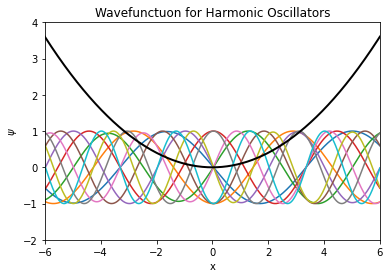

In [4]:
a = 1.0e-11
E1 =  100 # start Energy search at the well depth
dE = 1
npoints = 1000


E_SM = []

fig = plt.figure()
ax = fig.add_subplot(111)

# Bound states must have E < 0 for the square well. 
# Cut off after we have found a few states
while (E1 < 800-dE):

    if match(E1)*match(E1 + dE) < 0 :  # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        print('Energy', str(len(E_SM)), '= %.5feV'%(E))
        E_SM.append(E)
        
        dx = 16*a/npoints
        
        # for plotting, must ensure overlap of left and right solutions 
        p_up = QM(E, npoints = npoints+4, x_start = -10, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 10, x_end = 0+4*dx)
        
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        
        # full solution, combine up and down solutions
        psi_x = np.concatenate((p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x))
    #else : 
    #    print("No bracket, increasing energy to", E1+dE)
    E1 += dE

# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa)/10., color = 'k', lw =2)
ax.set_title('Wavefunctuon for Harmonic Oscillators')
ax.set_xlim([-6, 6])
ax.set_ylim([-2, 4])
ax.set_xlabel('x')
ax.set_ylabel('$\psi$')
plt.show()

In [5]:
print('dE between energy states:')
dE=[]
for i in range(len(E_SM)-1):
    dE.append(E_SM[i+1]-E_SM[i])
    print('dE between states {} and {}:'.format(i,i+1), round(E_SM[i+1]-E_SM[i],5), 'eV')

print('\nddE between dEs:')
for j in range(len(dE)-1):
    print('ddE:'.format(i,i+1), round(dE[j+1]-dE[j],4), 'eV')

dE between energy states:
dE between states 0 and 1: 44.27099 eV
dE between states 1 and 2: 51.08145 eV
dE between states 2 and 3: 57.89208 eV
dE between states 3 and 4: 64.70254 eV
dE between states 4 and 5: 71.51399 eV
dE between states 5 and 6: 78.32728 eV
dE between states 6 and 7: 85.13607 eV
dE between states 7 and 8: 91.94757 eV
dE between states 8 and 9: 98.75801 eV

ddE between dEs:
ddE: 6.8105 eV
ddE: 6.8106 eV
ddE: 6.8105 eV
ddE: 6.8114 eV
ddE: 6.8133 eV
ddE: 6.8088 eV
ddE: 6.8115 eV
ddE: 6.8104 eV


Stable harnomic oscilatory wavefunctions are found around the quadratic potential with no runtime warning, but energy states are not evenly spaced. I think the error comes from rescaling the original Schrödinger's equation. The differnece between each excitation states increases by the same amount, but I was not able to find the source of this mathematical error in the equation.

Energy 0 = 138.02881eV
Energy 1 = 414.08644eV
Energy 2 = 690.14406eV
Energy 3 = 966.20169eV
Energy 4 = 1242.25932eV
Energy 5 = 1518.31696eV
Energy 6 = 1794.37463eV
Energy 7 = 2070.43255eV
Energy 8 = 2346.49202eV
Energy 9 = 2622.55998eV


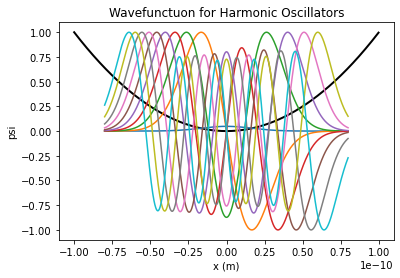

In [6]:
### MODIFIED SAMPLE CODE FROM NEWMAN BOOK ###
# Constants
e = 1.602e-19 #J
V0 = 50.0*e #Js
a = 1e-11 #m
x_0 = -1e-10
x_f = 1e-10
hbar = 1.05457e-34  # J*s
m = 9.10938e-31 # electron mass in kg
N = 1000  # number of steps to use in Runge-Kutta
h = (x_f - x_0) / N
psi_0 = 0.0

def psi(E):
#solve wavefunction for particular energy with RK4

    def f(r, x):
    #system of ODE
        
        def V(x):
        #potential
            return V0/a**2*x**2 #+ 0.1*V0/a**4*x**4 
        
        psi = r[0]
        phi = r[1]
        fpsi = phi
        fphi = (2*m/hbar**2)*(V(x)-E)*psi
        return np.array([fpsi,fphi],float)

    r = np.array([psi_0, 0.01] ,float)
    wavefunction = []
    
    #RK4
    for x in np.arange(x_0, x_f, h):
        wavefunction.append(r[0])
        k1 = h * f(r, x)
        k2 = h * f(r + 0.5 * k1, x + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, x + 0.5 * h)
        k4 = h * f(r + k3, x + h)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return np.array(wavefunction, float)

def secant_root(E1, E2):
    target_accuracy = e/1000
    wavefunction = psi(E1)
    psi2 = wavefunction[N - 1]
    
    while np.abs(E1 - E2) > target_accuracy:
        wavefunction = psi(E2)
        psi1, psi2 = psi2, wavefunction[N - 1]
        E1, E2 = E2, E2 - psi2*(E2-E1) / (psi2-psi1)
    
    return E2/e , wavefunction/max(wavefunction)

def potential(x):
    return (x/(10*a))**2 #+ (x/(10*a))**4

xpoints = np.arange(x_0, x_f, h)
x_range = slice(N//10, 9*N//10, 1)
plt.plot(xpoints,potential(xpoints),color = 'k', lw =2)

E_HO=[]
for ii in range(0,2700,290):
    En,Psi=secant_root(ii*e, (ii+10)*e)
    En=round(En,5)
    if En not in E_HO:
        print('Energy', str(len(E_HO)), '= %.5feV'%(En))
        E_HO.append(En)
        plt.plot(xpoints[x_range], Psi[x_range])
    else:
        continue

plt.title('Wavefunctuon for Harmonic Oscillators')
plt.xlabel('x (m)')
plt.ylabel('psi')
plt.show()

In [7]:
print('dE between energy states:')
dE=[]
for i in range(len(E_HO)-1):
    dE.append(E_HO[i+1]-E_HO[i])
    print('dE between states {} and {}:'.format(i,i+1), round(E_HO[i+1]-E_HO[i],5), 'eV')

dE between energy states:
dE between states 0 and 1: 276.05763 eV
dE between states 1 and 2: 276.05762 eV
dE between states 2 and 3: 276.05763 eV
dE between states 3 and 4: 276.05763 eV
dE between states 4 and 5: 276.05764 eV
dE between states 5 and 6: 276.05767 eV
dE between states 6 and 7: 276.05792 eV
dE between states 7 and 8: 276.05947 eV
dE between states 8 and 9: 276.06796 eV


I came back after doing part b) and used sample code from the Newman textbook that uses RK4 and the secant method to find roots. I did not need to rewrite the original system of ODEs and found solutions at equally spaced intervals this time. Even though the secant method is very susceptible to errors in the periodic wavefunctions, the equally spaced energy levels suggest I have found the correct values.

(b) Now modify your program to calculate the same ten energies for the anharmonic oscillator with $V(x) = V_0x^2/a^2 + V_0'x^4/a^4$, with $V_0' = 0.1V_0$ and the same parameter values as in part a. Plot level number vs. energy for the haromonic and anharmonic oscillator on the same graph (you may choose units of energy where $\hbar = m = 1$. What do you notice about how the energy varies with level number for each case?

Energy 0 = 159.23135eV
Energy 1 = 509.15896eV
Energy 2 = 912.33317eV
Energy 3 = 1354.81455eV
Energy 4 = 1829.73999eV
Energy 5 = 2332.70673eV
Energy 6 = 2860.58979eV
Energy 7 = 3411.02818eV
Energy 8 = 3982.16084eV
Energy 9 = 4572.47460eV


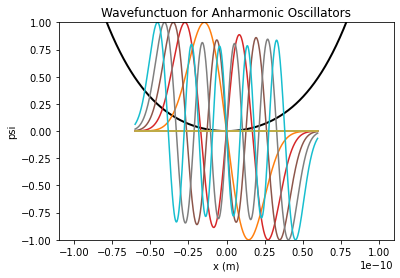

In [13]:
### MODIFIED SAMPLE CODE FROM NEWMAN BOOK ###
# Constants
e = 1.602e-19 #J
V0 = 50.0*e #Js
a = 1e-11 #m
x_0 = -1e-10
x_f = 1e-10
hbar = 1.05457e-34  # J*s
m = 9.10938e-31 # electron mass in kg
N = 1000  # number of steps to use in Runge-Kutta
h = (x_f - x_0) / N
psi_0 = 0.0

def psi(E):
#solve wavefunction for particular energy with RK4

    def f(r, x):
    #system of ODE
        
        def V(x):
        #potential
            return V0/a**2*x**2 + 0.1*V0/a**4*x**4 
        
        psi = r[0]
        phi = r[1]
        fpsi = phi
        fphi = (2*m/hbar**2)*(V(x)-E)*psi
        return np.array([fpsi,fphi],float)

    r = np.array([psi_0, 0.01] ,float)
    wavefunction = []
    
    #RK4
    for x in np.arange(x_0, x_f, h):
        wavefunction.append(r[0])
        k1 = h * f(r, x)
        k2 = h * f(r + 0.5 * k1, x + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, x + 0.5 * h)
        k4 = h * f(r + k3, x + h)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return np.array(wavefunction, float)

def secant_root(E1, E2):
    target_accuracy = e/1000
    wavefunction = psi(E1)
    psi2 = wavefunction[N - 1]
    
    while np.abs(E1 - E2) > target_accuracy:
        wavefunction = psi(E2)
        psi1, psi2 = psi2, wavefunction[N - 1]
        E1, E2 = E2, E2 - psi2*(E2-E1) / (psi2-psi1)
    
    return E2/e , wavefunction/max(wavefunction)

def potential(x):
    return (x/(10*a))**2 + (x/(10*a))**4

xpoints = np.arange(x_0, x_f, h)
x_range = slice(2*N//10, 8*N//10, 1)
plt.plot(xpoints,potential(xpoints),color = 'k', lw =2)

E_AO=[]
for ii in range(0,4800,290):
    En,Psi=secant_root(ii*e, (ii+10)*e)
    En=round(En,5)
    if En not in E_AO:
        print('Energy', str(len(E_AO)), '= %.5feV'%(En))
        E_AO.append(En)
        plt.plot(xpoints[x_range], Psi[x_range])
    else:
        continue

plt.title('Wavefunctuon for Anharmonic Oscillators')
plt.ylim([-1,1])
plt.xlabel('x (m)')
plt.ylabel('psi')
plt.show()

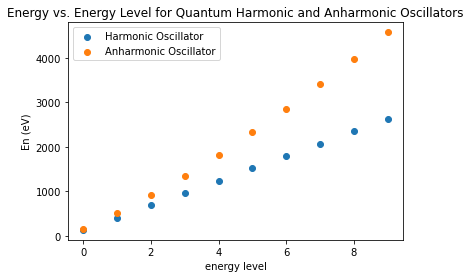

In [10]:
plt.scatter(range(0,10,1),E_HO, label='Harmonic Oscillator')
plt.scatter(range(0,10,1),E_AO, label='Anharmonic Oscillator')
plt.xlabel('energy level')
plt.ylabel('En (eV)')
plt.title('Energy vs. Energy Level for Quantum Harmonic and Anharmonic Oscillators')
plt.legend()
plt.show()

I did not know how to rewrite the Schrödinger's equation with the new potential to avoid numerical errors from dividing by very small numbers, but I was able to bypass this problem with the sample code from Newman's textbook, which uses RK4 and the secant method instead of the shooting method. Due to the nature of the Secant Method, the periodic form of the wavefunction makes root finding very error-prone, and it took me some guess and trial with the search range and step size of E.

Looking at the graph of energy vs. level number for harmonic oscillator (HO) and anharmonic oscillator (AO), it seems like the HO energy increases at a constant rate, while the energy for AO increases more rapidly at a exponential or power rate. 

(c) Modify your program further to calculate the wavefunctions of the anharmonic oscillator for the three lowest energy states and make a plot of them, all on the same axes, as a function of x over a modest range near the origin — say $x = −5a$ to $x = 5a$. You do not need to normalize the wavefunctions. Scale them so that all three curves fit on the same plot.

Energy 0 = 159.23135eV
Energy 1 = 509.15896eV
Energy 2 = 912.33317eV


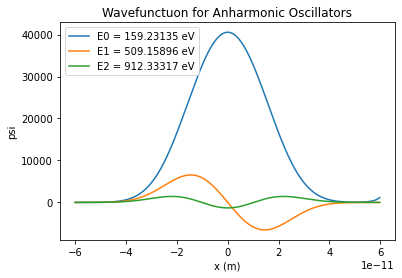

In [22]:
### MODIFIED SAMPLE CODE FROM NEWMAN BOOK ###
# Constants
e = 1.602e-19 #J
V0 = 50.0*e #Js
a = 1e-11 #m
x_0 = -1e-10
x_f = 1e-10
hbar = 1.05457e-34  # J*s
m = 9.10938e-31 # electron mass in kg
N = 1000  # number of steps to use in Runge-Kutta
h = (x_f - x_0) / N
psi_0 = 0.0

def psi(E):
#solve wavefunction for particular energy with RK4

    def f(r, x):
    #system of ODE
        
        def V(x):
        #potential
            return V0/a**2*x**2 + 0.1*V0/a**4*x**4 
        
        psi = r[0]
        phi = r[1]
        fpsi = phi
        fphi = (2*m/hbar**2)*(V(x)-E)*psi
        return np.array([fpsi,fphi],float)

    r = np.array([psi_0, 0.01] ,float)
    wavefunction = []
    
    #RK4
    for x in np.arange(x_0, x_f, h):
        wavefunction.append(r[0])
        k1 = h * f(r, x)
        k2 = h * f(r + 0.5 * k1, x + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, x + 0.5 * h)
        k4 = h * f(r + k3, x + h)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return np.array(wavefunction, float)

def secant_root(E1, E2):
    target_accuracy = e/1000
    wavefunction = psi(E1)
    psi2 = wavefunction[N - 1]
    
    while np.abs(E1 - E2) > target_accuracy:
        wavefunction = psi(E2)
        psi1, psi2 = psi2, wavefunction[N - 1]
        E1, E2 = E2, E2 - psi2*(E2-E1) / (psi2-psi1)
    
    return E2/e , wavefunction

xpoints = np.arange(x_0, x_f, h)
x_range = slice(2*N//10, 8*N//10, 1)

E_AO=[]
for ii in range(0,1000,290):
    En,Psi=secant_root(ii*e, (ii+10)*e)
    En=round(En,5)
    if En not in E_AO:
        print('Energy', str(len(E_AO)), '= %.5feV'%(En))
        plt.plot(xpoints[x_range], Psi[x_range], label='E{} = {} eV'.format(len(E_AO),En))
        E_AO.append(En)
    else:
        continue

plt.title('Wavefunctuon for Anharmonic Oscillators')
#plt.ylim([-1,1])
plt.xlabel('x (m)')
plt.ylabel('psi')
plt.legend()
plt.show()

2.(a) Use the Jacobi method to compute the electric potential between two infinitely long concentric square cylinders. Assume the cylinders have sides of $5.0$ and $25.0$. Assume that the inner conductor is held at $V = 1$, and the outer at $V =0$. You can use a grid spacing of one in your Jacobi method. Make a contour plot of the potential and some one dimensional slices across rows of the grid.

In [140]:
from numba import jit

###Jacobi Algorithm###
@jit
def jacobi(V,Vnew,M,N):
    for ii in range(M):
        for jj in range(N):
            if ii == 0 or jj == 0 or ii == M or jj == N:
                Vnew[ii,jj] = V[ii,jj]
            else :
                Vnew[ii,jj] = (V[ii+1,jj]+V[ii-1,jj]+V[ii,jj+1]+V[ii,jj-1])/4
    return Vnew

def invDel2_loops(b, boundary,  dx=1.0, converge = 1e-6):
    """ This is the Jacobi algorithim 
    Specialized to two dimensions so that plotting is easier.
    """
    V = boundary(np.zeros(b.shape, float))  # potential values at step n of the iteration   
    Vnew = np.zeros(b.shape, float) # updated potential 
    Npoints = len(b.flatten())

    t = 0  # transient before checking for convergence
    dV = converge*10  #make sure we run through transient
    
    while(dV > converge): 
        # move the loops outside to use jit
        Vnew = jacobi(V,Vnew,V.shape[0]-1,V.shape[1]-1)
        
        # enforce bc's at every iteration
        Vnew = boundary(Vnew)

        # wait for transient before checking convergence
        if t > 100 : 
            dV = np.sum(abs(Vnew - V))/Npoints
        # Note the explicit indexing (V[:,:]) without it Vnew will be updated with V
        V[:,:] = Vnew 
        # for mor complex objects i.e. list with sublists use deepcopy
        t+=1
   
    return Vnew

In [163]:
### Calculating V and E, and plot contour
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
def solve_V_E(boundary):
    N = 100 #grid points
    dx = 1/N

    # generate coordinates for each grid point
    # only required for plotting E-field
    X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))

    # the charge distrubution defines space for us
    # empty space, no charge
    rho = np.zeros([N+1, N+1])
    #rho = pipe(rho)*-5000

    # solution from relaxation
    phi = invDel2_loops(rho, boundary, dx)

    # Calculate the electric field
    EY, EX = -1*np.array(np.gradient(phi))
    magE = np.sqrt(EX**2 + EY**2)

    # Note, this step was not completed in shared notebook, so plots will look a bit messy
    # supress division by zero error output
    np.seterr(divide = 'ignore', invalid = 'ignore')
    EX= np.divide(EX,magE)
    EY= np.divide(EY,magE)
    
    ###Plotting###
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # plot potential
    m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

    # add an axes to put colorbar is custom location
    cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
    # create colorbar
    cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
    cbar.set_label('Potential')

    # add contour lines
    ax1.contour(X,Y,phi, cmap = 'RdBu')
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    # plot E-field 
    m2 = ax2.pcolormesh(X,Y,magE, cmap = 'Reds')

    cax2 = fig.add_axes([0.62,0.87,0.3,0.04])
    cbar2 = fig.colorbar(m2,cax2,orientation = 'horizontal', ticklocation = 'top' )
    cbar2.set_label('Electric Field Strength')
    ax2.quiver(X[::8,::8],Y[::8,::8],EX[::8,::8], EY[::8, ::8], units = 'width') 
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")

    fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.35, hspace = 0.35)

In [164]:
### Define Boundaries###
def cocen_sqr_cyl(phi):
    """ 
    define cocentric square cylinder potential
    """ 
    n, m = np.shape(phi)
    mid = n//2
    big_h = n//4  
    small_h = m//20
    
    big_high = mid + big_h
    big_low = mid - big_h
    small_high = mid + small_h
    small_low = mid - small_h
    
    phi[big_low:big_high, big_low] =  0
    phi[big_low:big_high, big_high] =  0
    phi[big_low, big_low:big_high] =  0
    phi[big_high, big_low:big_high] =  0
    
    phi[small_low:small_high, small_low] =  1
    phi[small_low:small_high, small_high] =  1
    phi[small_low, small_low:small_high] =  1
    phi[small_high, small_low:small_high] =  1
    
    return phi

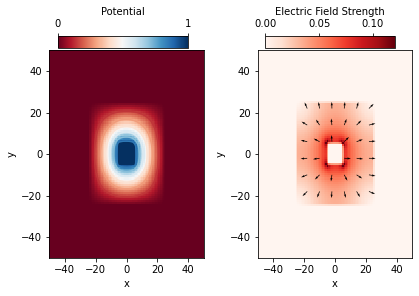

In [165]:
solve_V_E(cocen_sqr_cyl)

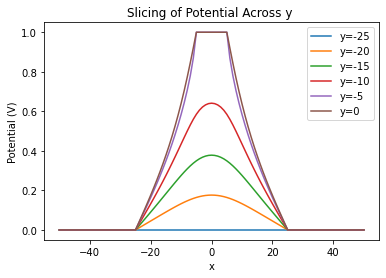

In [166]:
N = 100 #grid points
dx = 1/N
rho = np.zeros([N+1, N+1])
phi = invDel2_loops(rho, cocen_sqr_cyl, dx)

#slice across rows of the grid.
x = np.linspace(-50, 50, 101)
plt.plot(x,phi[25,:], label = "y=-25")
plt.plot(x,phi[30,:], label = "y=-20")
plt.plot(x,phi[35,:], label = "y=-15")
plt.plot(x,phi[40,:], label = "y=-10")
plt.plot(x,phi[45,:], label = "y=-5")
plt.plot(x,phi[50,:], label = "y=0")
plt.xlabel("x")
plt.ylabel("Potential (V)")
plt.title("Slicing of Potential Across y ")
plt.legend()
plt.show()

(b) Compute the electric potential and field for a point charge located at the center of a parallel plate capacitor in two dimensions. Make a contour plot of the potential and field. Study how the equipotential contours are affected by the proximity of the charge to one of the capacitor places.

In [181]:
def parallel_plate_charge(phi):
    n, m = np.shape(phi)
    w = n//2
    h = n//3  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # positioin of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] =  1
    return phi

def parallel_plate_charge(phi):
    n, m = np.shape(phi)
    w = n//2
    h = n//3  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # positioin of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] =  1
    
    phi[w,w] = -1
    return phi

def parallel_plate_left_charge(phi):
    n, m = np.shape(phi)
    w = n//2
    h = n//3  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # positioin of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] =  1
    
    phi[w,w-h//4] = -1
    return phi

def parallel_plate_right_charge(phi):
    n, m = np.shape(phi)
    w = n//2
    h = n//3  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # positioin of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] =  1
    
    phi[w,w+h//4] = -1
    return phi


def parallel_plate_up_charge(phi):
    n, m = np.shape(phi)
    w = n//2
    h = n//3  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # positioin of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] =  1
    
    phi[w+h//4,w+h//4] = -1
    return phi

Parallel plates without charge


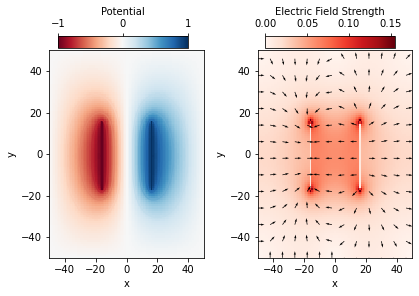

In [189]:
print('Parallel plates without charge')
solve_V_E(parallel_plate)

Negative charge in the middle


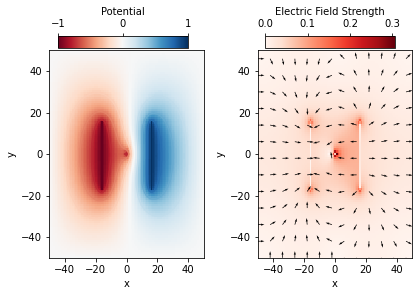

In [188]:
print('Negative charge in the middle')
solve_V_E(parallel_plate_charge)

Negative charge shifted towards negative plate


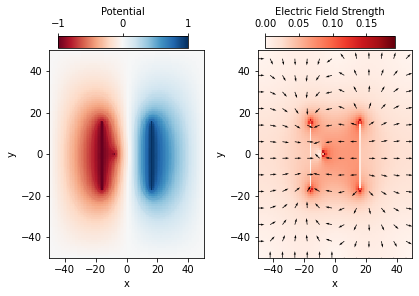

In [187]:
print('Negative charge shifted towards negative plate')
solve_V_E(parallel_plate_left_charge)

Negative charge shifted towards positive plate


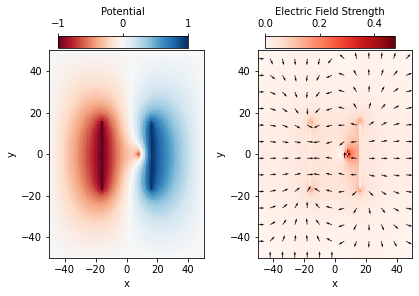

In [184]:
print('Negative charge shifted towards positive plate')
solve_V_E(parallel_plate_right_charge)

Negative charge shifted up and towards positive plate


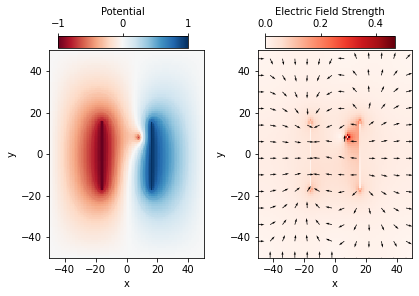

In [185]:
print('Negative charge shifted up and towards positive plate')
solve_V_E(parallel_plate_up_charge)

When the point charge is on the plate with the same sign, the potential is not affected at all. However, the deformation of potential between the paralle plates increase as the point charge moves closer towards the plate with the opposite sign. 